In [32]:
import sys
sys.path.append("../scripts")
from get_sharpe import getSharpe
from volatility import get_volatility

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Compute the covariance matrix 

In [22]:
TSLA_df = pd.read_csv("../data/TSLA_10years_data.csv")
SPY_df = pd.read_csv("../data/SPY_10years_data.csv")
BND_df = pd.read_csv("../data/BND_10years_data.csv")

In [23]:
data = {
    "TSLA": TSLA_df["Close"].pct_change() * 100,
    "SPY": SPY_df["Close"].pct_change() * 100,
    "BND": BND_df["Close"].pct_change() * 100
}

In [24]:
df = pd.DataFrame(data)
cov_matrix = df.cov()

In [25]:
cov_matrix

,TSLA,SPY,BND
TSLA,13.925420,2.111293,0.076342
SPY,2.111293,1.328132,0.046392
BND,0.076342,0.046392,0.120422


# Sharpe Ratio Portfolio

* The risk-free rate (Rf) is the return an investor could earn with zero risk.

          let assume annual risk-free rate is 1%

In [ ]:
tsla_returns = TSLA_df["Close"].pct_change().dropna()

In [ ]:
TSLA_sharpe = getSharpe(tsla_returns)
TSLA_sharpe

np.float64(0.7894140805010981)

In [28]:
spy_returns = SPY_df["Close"].pct_change().dropna()
SPY_sharpe = getSharpe(spy_returns)
SPY_sharpe

np.float64(0.7376303346014144)

In [29]:
bnd_returns = BND_df["Close"].pct_change().dropna()
BND_sharpe = getSharpe(bnd_returns)
BND_sharpe

np.float64(0.17226818129133267)

# Risk optimization

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize


returns = pd.DataFrame(data).dropna()  

returns = returns / 100

mu = returns.mean() * 252
cov_matrix = returns.cov() * 252
assets = returns.columns
n_assets = len(assets)

def portfolio_performance(weights, mu, cov):
    ret = np.dot(weights, mu)
    std = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
    sharpe = ret / std 
    return ret, std, sharpe

def min_volatility(weights, mu, cov):
    return np.sqrt(np.dot(weights.T, np.dot(cov, weights)))

def neg_sharpe(weights, mu, cov):
    ret, std, sharpe = portfolio_performance(weights, mu, cov)
    return -sharpe  
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) 
bounds = tuple((0, 1) for _ in range(n_assets))  

initial_guess = n_assets * [1. / n_assets,]
opt_minvol = minimize(min_volatility, initial_guess,
                      args=(mu, cov_matrix), method='SLSQP',
                      bounds=bounds, constraints=constraints)
min_vol_weights = opt_minvol.x
min_vol_return, min_vol_std, _ = portfolio_performance(min_vol_weights, mu, cov_matrix)

opt_maxsharpe = minimize(neg_sharpe, initial_guess,
                         args=(mu, cov_matrix), method='SLSQP',
                         bounds=bounds, constraints=constraints)
max_sharpe_weights = opt_maxsharpe.x
max_sharpe_return, max_sharpe_std, max_sharpe_ratio = portfolio_performance(max_sharpe_weights, mu, cov_matrix)

ef_results = {
    'min_vol': {
        'weights': dict(zip(assets, min_vol_weights)),
        'return': min_vol_return,
        'stddev': min_vol_std,
    },
    'max_sharpe': {
        'weights': dict(zip(assets, max_sharpe_weights)),
        'return': max_sharpe_return,
        'stddev': max_sharpe_std,
        'sharpe': max_sharpe_ratio
    }
}

print("Minimum Volatility Portfolio:", ef_results['min_vol'])
print("Maximum Sharpe Portfolio:", ef_results['max_sharpe'])


Minimum Volatility Portfolio: {'weights': {'TSLA': np.float64(0.0), 'SPY': np.float64(0.05453472989211687), 'BND': np.float64(0.9454652701078832)}, 'return': np.float64(0.02632828323308963), 'stddev': np.float64(0.05415499830745207)}
Maximum Sharpe Portfolio: {'weights': {'TSLA': np.float64(0.11015939898871688), 'SPY': np.float64(0.31943513564925136), 'BND': np.float64(0.5704054653620318)}, 'return': np.float64(0.11001426090206555), 'stddev': np.float64(0.11433784207126771), 'sharpe': np.float64(0.9621859124601352)}


C:\Users\HP\AppData\Local\Temp\ipykernel_13892\3784098939.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ret_arr[i] = np.dot(weights, mu)
C:\Users\HP\AppData\Local\Temp\ipykernel_13892\3784098939.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vol_arr[i] = np.sqrt(np.dot(weights, np.dot(cov_matrix, weights.T)))


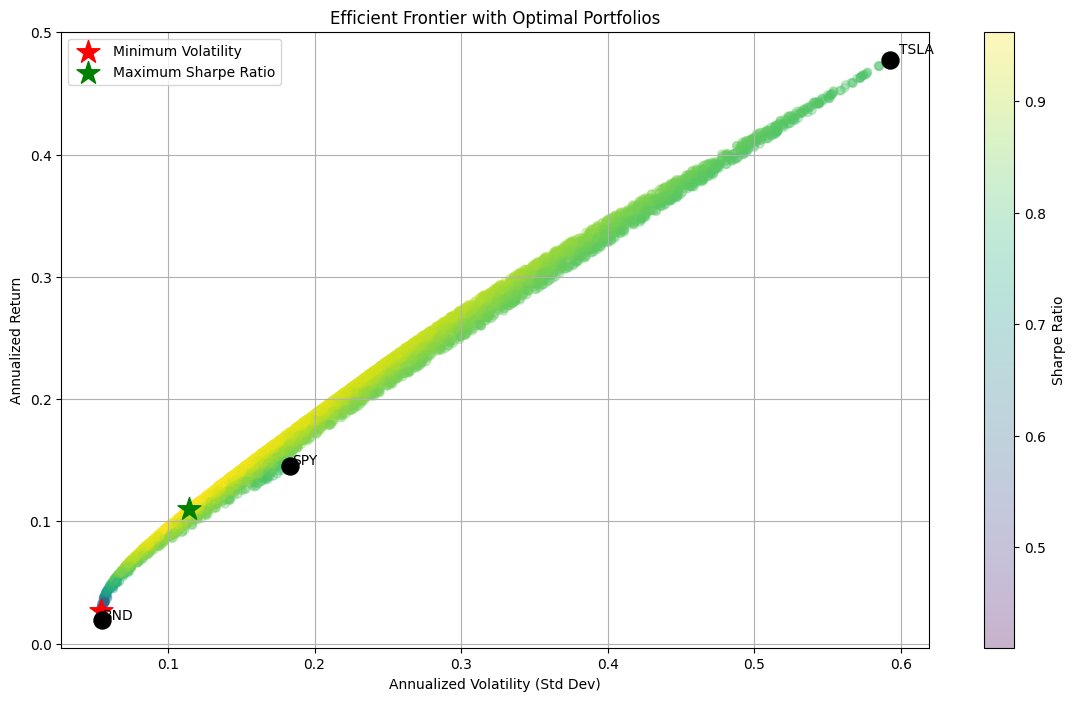

In [47]:

num_portfolios = 5000
all_weights = np.zeros((num_portfolios, n_assets))
ret_arr = np.zeros(num_portfolios)
vol_arr = np.zeros(num_portfolios)
sharpe_arr = np.zeros(num_portfolios)

np.random.seed(42)
for i in range(num_portfolios):
    weights = np.random.dirichlet(np.ones(n_assets), size=1)
    all_weights[i,:] = weights
    ret_arr[i] = np.dot(weights, mu)
    vol_arr[i] = np.sqrt(np.dot(weights, np.dot(cov_matrix, weights.T)))
    sharpe_arr[i] = ret_arr[i] / vol_arr[i]

plt.figure(figsize=(14,8))

plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis', alpha=0.3)
plt.colorbar(label='Sharpe Ratio')

plt.scatter(ef_results['min_vol']['stddev'], ef_results['min_vol']['return'],
            color='red', marker='*', s=300, label='Minimum Volatility')
plt.scatter(ef_results['max_sharpe']['stddev'], ef_results['max_sharpe']['return'],
            color='green', marker='*', s=300, label='Maximum Sharpe Ratio')

for i, asset in enumerate(assets):
    asset_vol = np.sqrt(cov_matrix.iloc[i,i])
    asset_ret = mu[asset]
    plt.scatter(asset_vol, asset_ret, color='black', marker='o', s=150)
    plt.text(asset_vol*1.01, asset_ret*1.01, asset)

plt.title('Efficient Frontier with Optimal Portfolios')
plt.xlabel('Annualized Volatility (Std Dev)')
plt.ylabel('Annualized Return')
plt.legend()
plt.grid(True)
plt.show()


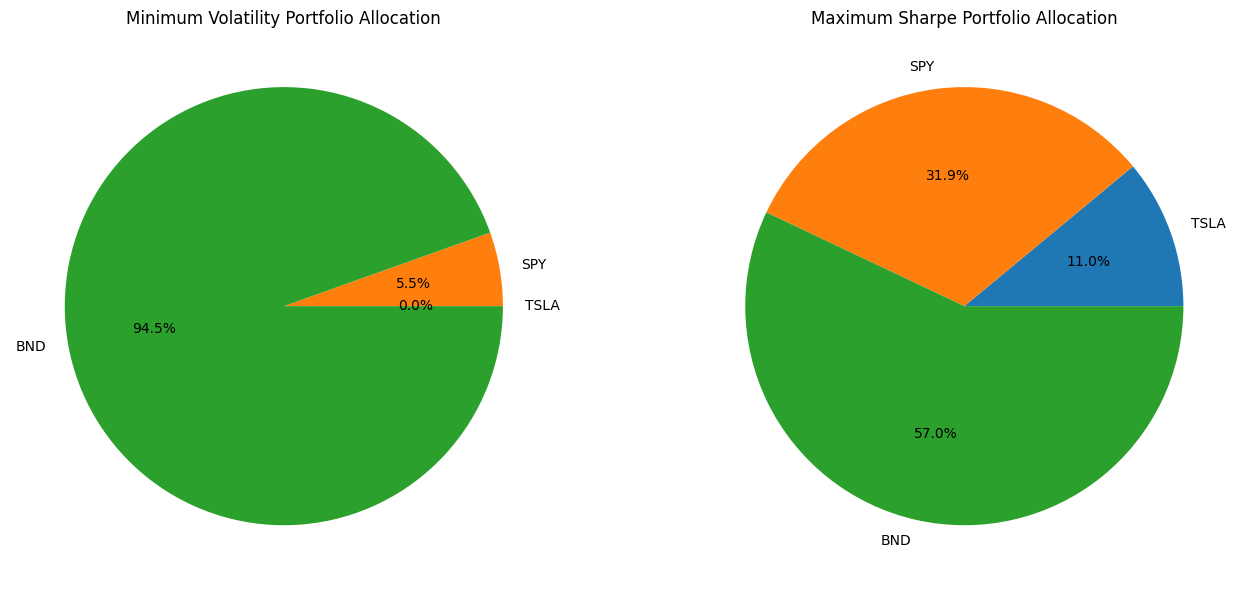

In [44]:

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.pie(list(ef_results['min_vol']['weights'].values()), labels=assets, autopct='%1.1f%%')
plt.title('Minimum Volatility Portfolio Allocation')

plt.subplot(1,2,2)
plt.pie(list(ef_results['max_sharpe']['weights'].values()), labels=assets, autopct='%1.1f%%')
plt.title('Maximum Sharpe Portfolio Allocation')

plt.tight_layout()
plt.show()

In [46]:
print("\nMinimum Volatility Portfolio:")
print(f"Expected Return: {ef_results['min_vol']['return']:.2%}")
print(f"Expected Volatility: {ef_results['min_vol']['stddev']:.2%}")
print("Asset Allocation:")
for asset, weight in ef_results['min_vol']['weights'].items():
    print(f"{asset}: {weight:.2%}")

print("\nMaximum Sharpe Ratio Portfolio:")
print(f"Expected Return: {ef_results['max_sharpe']['return']:.2%}")
print(f"Expected Volatility: {ef_results['max_sharpe']['stddev']:.2%}")
print(f"Sharpe Ratio: {ef_results['max_sharpe']['sharpe']:.2f}")
print("Asset Allocation:")
for asset, weight in ef_results['max_sharpe']['weights'].items():
    print(f"{asset}: {weight:.2%}")


Minimum Volatility Portfolio:
Expected Return: 2.63%
Expected Volatility: 5.42%
Asset Allocation:
TSLA: 0.00%
SPY: 5.45%
BND: 94.55%

Maximum Sharpe Ratio Portfolio:
Expected Return: 11.00%
Expected Volatility: 11.43%
Sharpe Ratio: 0.96
Asset Allocation:
TSLA: 11.02%
SPY: 31.94%
BND: 57.04%


In [48]:
min_df = pd.Series(dict(zip(assets, min_vol_weights)))
max_df = pd.Series(dict(zip(assets, max_sharpe_weights)))

In [50]:
min_df.to_csv('../data/min_vol_weights.csv')
max_df.to_csv('../data/max_sharpe_weights.csv')